In [66]:
import astropy
import numpy as np
import matplotlib.pyplot as plt
from sherpa.astro.data import DataPHA
from sherpa.astro.io import read_pha, read_arf, read_rmf
from astropy.io import fits
import os
from sherpa.astro.plot import DataPHAPlot
import copy
from sherpa.utils.logging import SherpaVerbosity
import pandas as pd

In [67]:
# for source_dir in os.listdir('spectra_files'):
#     source_path = os.path.join('spectra_files', source_dir)
#     if os.path.isdir(source_path):
#         for obsid_dir in os.listdir(source_path):
#             obsid_path = os.path.join(source_path, obsid_dir)
#             if os.path.isdir(obsid_path):
#                 obsid_trimmed = f'{obsid_path.split('/')[-2]}/{obsid_path.split('/')[-1]}'
#                 print(obsid_trimmed)

In [68]:
# Load in all of the spectra for each observation for each detector as DataPHA objects and in the 
# process assign the response files and background (and background subtract)

spectra = {}
for source_dir in os.listdir('spectra_files'):
    source_path = os.path.join('spectra_files', source_dir)
    if os.path.isdir(source_path):
        for obsid_dir in os.listdir(source_path):
            obsid_path = os.path.join(source_path, obsid_dir)
            if os.path.isdir(obsid_path):
                obsid_trimmed = f'{obsid_path.split('/')[-2]}/{obsid_path.split('/')[-1]}'
                if obsid_trimmed != 'her_x-1/01001899': # for some reason the rmf doesn't work with this one
                    print(f'Processing {obsid_trimmed}')

                    stokes = ['I', 'Q', 'U']
                    for stoke in stokes:
                        for det in range(1, 4):
                            for reg in ['src', 'bkg']:
                                spec_hdu = fits.open(f'{obsid_path}/ixpe_det{det}_{reg}_{stoke}.pha')
                                with SherpaVerbosity("ERROR"):
                                    pha = read_pha(spec_hdu)
                                if stokes == 'I':
                                    arf = read_arf(f'responses/ixpe_d{det}_20170101_alpha075_05.arf')
                                else:
                                    arf = read_arf(f'responses/ixpe_d{det}_20170101_alpha075_05.mrf')
                                rmf = read_rmf(f'responses/ixpe_d{det}_20170101_alpha075_02.rmf')
                                pha.set_response(arf, rmf)  
                                pha.set_analysis('energy')
                                pha.notice(2, 8)
                                # pha.subtract()
                                spectra[f'{obsid_trimmed}/det{det}_{stoke}_{reg}'] = pha
                        


Processing swift_j1727/03006001
Processing swift_j1727/02251301
Processing swift_j1727/02250901
Processing swift_j1727/02251001
Processing swift_j1727/03005801
Processing swift_j1727/02251101
Processing swift_j1727/03005701
Processing swift_j1727/02251201
Processing cen_x-3/01250201
Processing cen_x-3/01006501
Processing gro_j1008-57/02003501
Processing gro_j1008-57/02003601
Processing gx_5-1/02002799
Processing gx_9+1/03003801
Processing gx_3+1/03004101
Processing v395_car/03001201
Processing gx_9+9/01002401
Processing cir_x-1/02002699
Processing lmc_x-1/02001901
Processing 4u_1735-44/03004001
Processing sco_x-1/02002401
Processing 4u_1820-303/02002399
Processing cyg_x-3/02001899
Processing cyg_x-3/02250301
Processing cyg_x-3/03250301
Processing cyg_x-3/02009101
Processing smc_x-1/02007001
Processing smc_x-1/02007101
Processing smc_x-1/02007201
Processing gx_340+0/03009901
Processing gx_340+0/03003301
Processing cyg_x-2/01001601
Processing cyg_x-2/01006601
Processing exo_2030+375/0225

In [69]:
def rebin(energy, flux, bins):
    rebinnedFlux = np.histogram(energy, bins, weights=flux)[0]/np.histogram(energy, bins)[0]
    rebinnedEnergy = (bins[:-1] + bins[1:])/2
    return rebinnedEnergy, rebinnedFlux

def SumDetectorsAndBin(obsid_path, stoke, bins):
    srcCounts = 0
    bkgCounts = 0
    exposures = 0
    for det in range(1, 4):
        src = spectra[f'{obsid_path}/det{det}_{stoke}_src']
        bkg = spectra[f'{obsid_path}/det{det}_{stoke}_bkg']
        exposure = fits.open(f'spectra_files/{obsid_path}/ixpe_det{det}_src_{stoke}.pha')[0].header['EXPOSURE']
        srcCounts += src.to_plot()[1] * exposure
        bkgCounts += bkg.to_plot()[1] * exposure
        exposures += exposure
        
    srcFlux = srcCounts/exposures 
    bkgFlux = bkgCounts/exposures
    binnedSrcEnergy, binnedSrcFlux = rebin(src.to_plot()[0], srcFlux, bins)
    binnedBkgEnergy, binnedBkgFlux = rebin(bkg.to_plot()[0], bkgFlux, bins)

    # Background subtract
    binnedFlux = binnedSrcFlux - binnedBkgFlux
    binnedEnergy = binnedSrcEnergy
    return binnedEnergy, binnedFlux

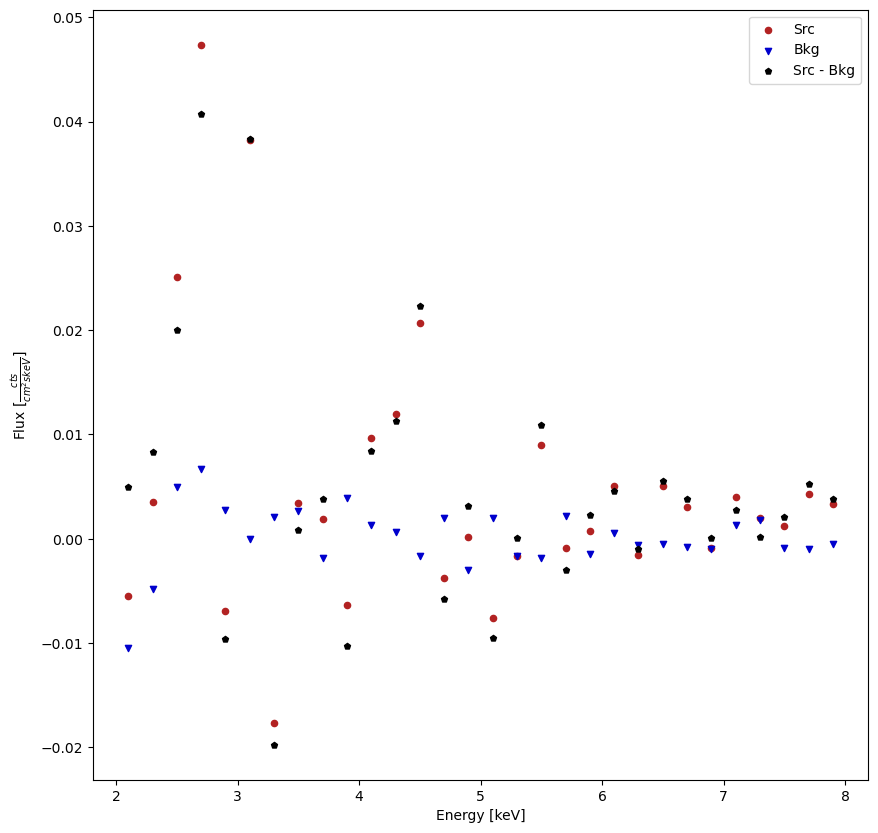

In [70]:
# Load in the background and source spectra for a source to visualize their difference, then background subtract.

srcSpec = spectra['cyg_x-1/03010101/det1_Q_src']
bkgSpec = spectra['cyg_x-1/03010101/det1_Q_bkg']
srcEnergy = srcSpec.to_plot()[0]
srcFlux = srcSpec.to_plot()[1]
bkgEnergy = bkgSpec.to_plot()[0]
bkgFlux = bkgSpec.to_plot()[1]
fig, ax = plt.subplots(figsize=(10,10))
# ax.scatter(srcEnergy, srcFlux, s=10, c='firebrick', label='Src')
# ax.scatter(bkgEnergy, bkgFlux, s=10, c='mediumblue', marker='v', label='Bkg')

binnedSrcEnergy, binnedSrcFlux = rebin(srcSpec.to_plot()[0], srcSpec.to_plot()[1], np.arange(2, 8+0.1, 0.2))
binnedBkgEnergy, binnedBkgFlux = rebin(bkgSpec.to_plot()[0], bkgSpec.to_plot()[1], np.arange(2, 8+0.1, 0.2))
binnedFlux = binnedSrcFlux - binnedBkgFlux

ax.scatter(binnedSrcEnergy, binnedSrcFlux, s=20, c='firebrick', label='Src')
ax.scatter(binnedBkgEnergy, binnedBkgFlux, s=20, c='mediumblue', marker='v', label='Bkg')
ax.scatter(binnedSrcEnergy, binnedFlux, s=20, c='black', marker='p', label='Src - Bkg')
ax.set_xlabel('Energy [keV]')
ax.set_ylabel(r'Flux $[\frac{cts}{cm^2 s keV}]$')
ax.legend()

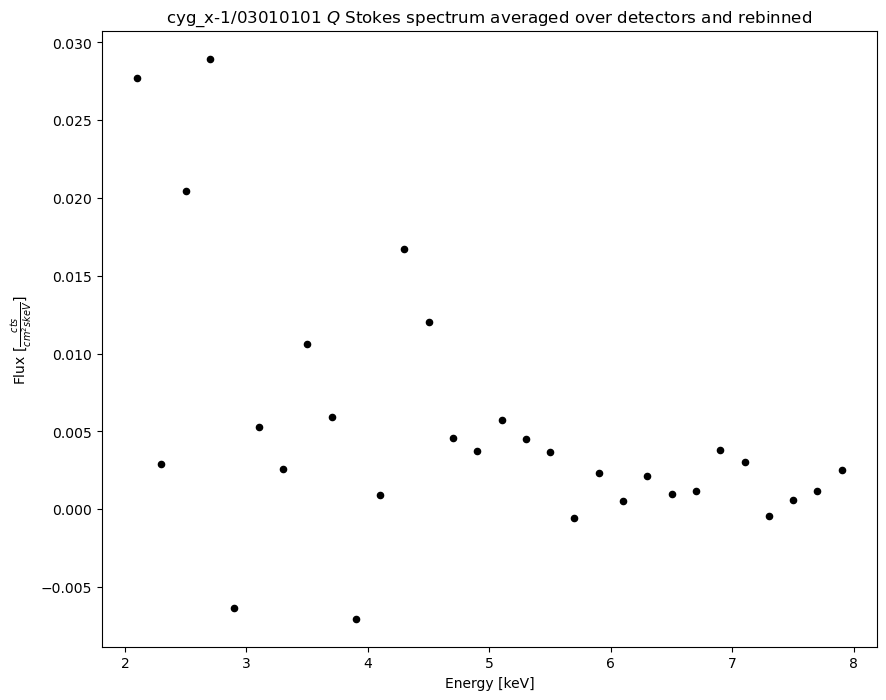

In [71]:
# Example of using the SumDetectorsAndBin function to sum the fluxes of all detectors and background subtract
# This is the object we probably want to deal with.
obs = 'cyg_x-1/03010101'
stoke = 'Q'
energy, flux = SumDetectorsAndBin(obs, stoke, np.arange(2, 8+0.1, 0.2))
fig, ax = plt.subplots(figsize=(10,8))
ax.scatter(energy, flux, s=20, c='black')
ax.set_xlabel('Energy [keV]')
ax.set_ylabel(r'Flux $[\frac{cts}{cm^2 s keV}]$')
ax.set_title(rf'{obs} ${stoke}$ Stokes spectrum averaged over detectors and rebinned')
plt.show()

20.1912028709973


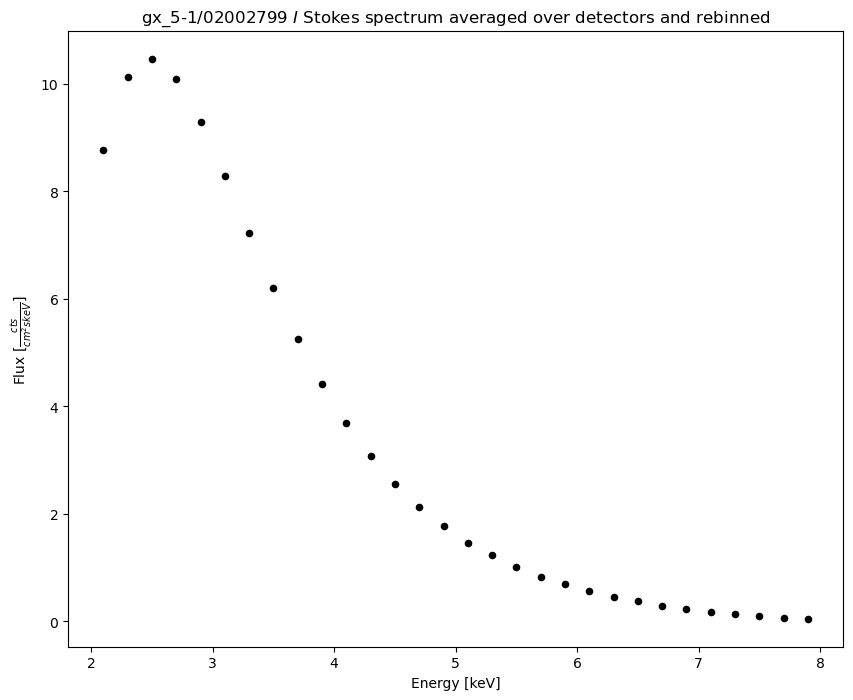

In [72]:
obs = 'gx_5-1/02002799'
stoke = 'I'
energy, flux = SumDetectorsAndBin(obs, stoke, np.arange(2, 8+0.1, 0.2))
# stoke = 'Q'
# energy, qflux = SumDetectorsAndBin(obs, stoke, np.arange(2, 8+0.1, 0.2))
fig, ax = plt.subplots(figsize=(10,8))
ax.scatter(energy, flux, s=20, c='black')
ax.set_xlabel('Energy [keV]')
ax.set_ylabel(r'Flux $[\frac{cts}{cm^2 s keV}]$')
ax.set_title(rf'{obs} ${stoke}$ Stokes spectrum averaged over detectors and rebinned')

print(np.sum(flux*.2))

# spec_hdu = fits.open(f'spectra_files/{obs}/ixpe_det1_src_{stoke}.pha')
# pha = read_pha(spec_hdu)
# arf = read_arf(f'responses/ixpe_d1_20170101_alpha075_05.arf')
# rmf = read_rmf(f'responses/ixpe_d1_20170101_alpha075_02.rmf')
# pha.set_response(arf, rmf)  
# pha.set_analysis('energy', 'rate')
# pha.notice(2, 8)
# # spec_hdu[1].header
# pha

In [85]:
obs = 'cen_x-3/01250201'
stokes = {'I':0, 'Q':0, 'U':0}

for stoke in stokes: 
    energy, flux = SumDetectorsAndBin(obs, stoke, np.arange(2, 8+0.1, 6))
    # print(flux)
    stokes[stoke] = flux


PD = np.sqrt(stokes['Q']**2 + stokes['U']**2)/stokes['I']
PD2 = np.sqrt(stokes['Q']**2 + stokes['U']**2)
PA = np.arctan2(stokes['U'], stokes['Q'])/2
print(f'Polarization Degree: {PD}')
print(f'Polarization Degree2: {PD2}')
# print(f'Polarization Angle: {PA*180/np.pi}')
# print(f'Normalized Q: {stokes["Q"]}')
# print(f'Normalized U: {stokes["U"]}')

Polarization Degree: [0.02084674]
Polarization Degree2: [0.01197638]


In [74]:
binSize = 0.2
for source_dir in os.listdir('spectra_files'):
    source_path = os.path.join('spectra_files', source_dir)
    if os.path.isdir(source_path):
        for obsid_dir in os.listdir(source_path):
            obsid_path = os.path.join(source_path, obsid_dir)
            if os.path.isdir(obsid_path):
                obsid_trimmed = f'{obsid_path.split('/')[-2]}/{obsid_path.split('/')[-1]}'
                if obsid_trimmed != 'her_x-1/01001899': # for some reason the rmf doesn't work with this one
                    print(f'Processing {obsid_trimmed}')
                    obsPD = pd.DataFrame()
                    stokes = ['I', 'Q', 'U']
                    for stoke in stokes:
                        energy, flux = SumDetectorsAndBin(obsid_trimmed, stoke, np.arange(2, 8+0.1, binSize))
                        obsPD['energy'] = energy
                        obsPD[f'{stoke}'] = flux
                    # obsPD.to_csv(f'spectra_files/{obsid_trimmed}/spectra_{binSize}.csv', index=False)

Processing swift_j1727/03006001
Processing swift_j1727/02251301
Processing swift_j1727/02250901
Processing swift_j1727/02251001
Processing swift_j1727/03005801
Processing swift_j1727/02251101
Processing swift_j1727/03005701
Processing swift_j1727/02251201
Processing cen_x-3/01250201
Processing cen_x-3/01006501
Processing gro_j1008-57/02003501
Processing gro_j1008-57/02003601
Processing gx_5-1/02002799
Processing gx_9+1/03003801
Processing gx_3+1/03004101
Processing v395_car/03001201
Processing gx_9+9/01002401
Processing cir_x-1/02002699
Processing lmc_x-1/02001901
Processing 4u_1735-44/03004001
Processing sco_x-1/02002401
Processing 4u_1820-303/02002399
Processing cyg_x-3/02001899
Processing cyg_x-3/02250301
Processing cyg_x-3/03250301
Processing cyg_x-3/02009101
Processing smc_x-1/02007001
Processing smc_x-1/02007101
Processing smc_x-1/02007201
Processing gx_340+0/03009901
Processing gx_340+0/03003301
Processing cyg_x-2/01001601
Processing cyg_x-2/01006601
Processing exo_2030+375/0225

Probably want to do the normalized Q and U spectra (could also do the analysis on I, more likely to get results but it's already been done I think). This just means taking the Q and U spectra and dividing by the I spectrum. 

Also think we should rotate the Q and U data so that the PA is 0 (some constant value)